In [2]:
import autograd.numpy as np
from autograd.numpy import linalg
from autograd.numpy.random import poisson, normal, multivariate_normal
from autograd import grad
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt

Defining Negative Poisson GP likelihood function in terms of observed counts $n_i$, mean model $y_i$, mean $\mu_i$, signal $s_i$, and GP kernel $\Sigma_{ij}$, we have the function:

$l(n_i, y_i | \mu_i, s_i, \Sigma_{ij}) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{y} - \vec{\mu})^T \Sigma^{-1} (\vec{y} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i)$

Split into terms:

$\begin{align*}
t1 &= -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} \text{(constants, Gaussian)}\\
t2 &= - \frac{1}{2} \left( (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) \text{(Gaussian)}\\
t3 &= \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) \text{(Poisson)}
\end{align*}$

In [3]:
#Defining Poisson GP log-likelihood function, returns negative likelihood (for optimization purposes)
def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None):
    #If inverse kernel matrix is not provided, compute it
    if(invcov == None):
        invcov = linalg.inv(cov)
    det = linalg.det(cov)
  
    #Checking that input arrays are all same-lenthed
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    
    #Computing 3 terms defined in above cell
    t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = np.sum(ni * np.log(mu + s) - (mu + s))
    result =  t2 + t3 + t1
    
    #Case handling for negative input
    if np.isnan(result)==True:
        result = -np.infty

    return -result               
    
neg_log_like_PGP_grad = grad(neg_log_like_PGP)

Setting the models for a true mean function (unknown) and an approximate mean function (guessed):


$\begin{align*}
\mu_{true, i} &= \frac{1}{ln(x_i+1)}\\
y_i(\theta_{y}) &= \frac{a}{(b*x_i+c)^2}+d, \theta_{y} = \{ a,b,c,d\}
\end{align*}$


In [4]:
#Define the true mean
def true_mu(x):
    return (1./np.log(.05*x+1))

#Define the approximate mean (model)
def y_model(x):
    return 1./(np.power(x+.3,2))

#Introduce some fitting parameters, should we want to change the true mean
def y_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

#reformatted to work with certain optimizers
def y_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return y_opt(x, params)

#define a simple kernel function (exponential)
def kernel_func_exp(x1,x2, params):
    A = params[0]
    l = params[1]
    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

#define a more complex kernel function (Gibbs)
def kernel_func_gibbs(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    l1 = (b * x1) + c
    l2 = (b * x2) + c
    lam = np.sqrt((2*l1*l2)/((l1**2)+(l2**2)))
    result = A * lam * np.exp(-(((x1-x2)**2)/((l1**2)+(l2**2)))+((d-(x1+x2))/(2.*a)))
    return result

#generate a kernel matrix given input coordinates, kernel function, and paramters for said kernel function
def make_kernel(x, k, params):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    return cov

#computes predictive distribution for a GP given observation coordinates, observations, GP mean, kernel matrix, and uncertainty measurements
def predict(t, n, y, cov, sigma):
    N = len(t)
    p_dist = np.empty(N)
    v_dist = np.empty(N)
    for i in range(N):
        inv = linalg.inv(cov+np.diag(np.power(sigma,2)))
        p_dist[i] = y[i] + cov[i].T.dot(inv.dot(n-y))
        v_dist[i] = cov[i][i] - cov[i].T.dot(inv.dot(cov[i]))
        if np.isnan(v_dist[i]):
            print ("NAN, cov diag = " + str(cov[i][i]) + "\t other term: " + str(cov[i].T.dot(inv.dot(cov[i]))))
    return p_dist, v_dist


In [5]:
#initializing true mu, a smooth version for plotting, and a sparse version for computations
N = 30
params_test = [25, 6., .3, 0.]
start = 2
stop = 20
scale = 2.5
t = np.linspace(start, stop, N)
t_smooth = np.linspace(start, stop, 100)
mu_test =  scale * true_mu(t)
mu_test = mu_test - int(mu_test[-1:])
mu_smooth = scale * true_mu(t_smooth)
mu_smooth = mu_smooth - int(mu_smooth[-1:])

#setting options for the optimizer
options={'ftol' :  np.finfo(float).eps, 'maxfun': 1.5e5, 'maxiter': 1.5e5, 'gtol': np.finfo(float).eps}

#initializing storage arrays for multiple runs
n_array = []
mu_GP_array = []
mu_GP2_array = []
mu_PGP_array = []
y_array = []

\begin{align*}
\Sigma_{ij}(\theta_{\Sigma}) &= A \lambda e^{-\frac{(x_i-x_j)^2}{l(x_i)^2+l(x_j)^2}+\frac{d-(x_i+x_j)}{(2.*a))}}, l(x) = bx + c, \lambda = \sqrt{\frac{2l(x_i)l(x_j)}{l(x_i)^2+l(x_j)^2}}, \theta_{\Sigma} = \{A, a , b, c, d \}
\end{align*}

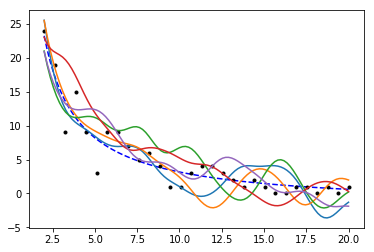

In [6]:
#completing a sample run to ensure everything is working properly

#draw a poisson sampling of the true mean
n_test = poisson(mu_test)

#setting the kernel parameters is hard, so let's plot some samples of a GP given our kernel parameters to ensure it looks correct
k_params = [5, 1e5, 0., 1.3, 100.]
cov_PGP_smooth = make_kernel(t_smooth, kernel_func_gibbs, k_params)
plt.plot(t_smooth, mu_smooth, 'b--', label = "True Mean")
plt.plot(t, n_test, 'k.', label = "counts")
for i in range(5):
    sample = np.random.multivariate_normal(mu_smooth, cov_PGP_smooth)
    plt.plot(t_smooth, sample)
    
plt.show()

In [14]:
#if our GP samples look good, run a test case to ensure our optimizer properly converges
n_test = poisson(mu_test)
n_err = np.sqrt(n_test)
model_test = mu_test
s_test = np.zeros(N)
cov_PGP = make_kernel(t, kernel_func_gibbs, k_params)
boundarray = [(None,None) for i in range(N)]

#compute the predictive mean for the case where our uncertainty is the square root of the mean model
pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(model_test))
pred_unc = np.sqrt(pred_var)

#compute the predictive mean for the case where our uncertainty is the square root of the observations
pred2, pred2_var = predict(t, n_test, model_test, cov_PGP, n_err)
pred2_unc = np.sqrt(pred2_var)

#find a minimum in likelihoodspace using the Poisson-Gaussian model
soln_PGP = minimize(neg_log_like_PGP, model_test,  method="L-BFGS-B", bounds = boundarray, args = (s_test, n_test, model_test, cov_PGP), options = options)
PGP_fit = soln_PGP.x
PGP_fit_unc = np.sqrt(np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
print soln_PGP

      fun: -1547.7981575269596
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.09133601,  0.23883331, -0.45281467,  0.68766894, -0.52043561,
        0.54990323, -0.60592811,  1.25044153, -1.70914518,  2.20782113,
       -2.78430434,  3.49655238, -4.07599146,  4.4891749 , -4.81029474,
        4.90886123, -4.73160071,  4.45784281, -4.14038368,  3.65234882,
       -3.15321813,  2.81565917, -2.60329216,  2.32817001, -1.8461833 ,
        0.98543751,  0.13505996, -0.54619704,  0.57825673, -0.26338967])
  message: 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 150009
      nit: 4198
   status: 1
  success: False
        x: array([23.97532315, 17.83089814, 13.527901  , 10.21440421,  7.73486463,
        6.03671162,  5.02498829,  4.58325432,  4.56762194,  4.78871876,
        5.01698358,  5.01666416,  4.62555087,  3.85578598,  2.9452878 ,
        2.25709302,  1.99435086,  1.9931577 ,  1.93211615,  1.75452412,
        1.6802634 ,  1.75324032,  1.66

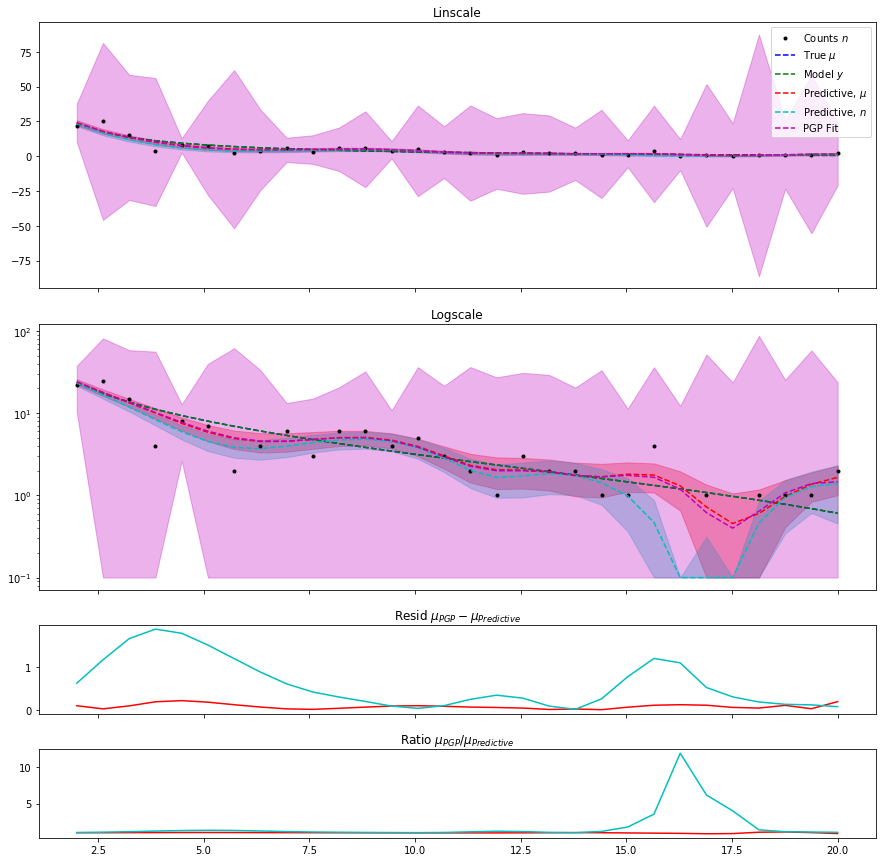

In [15]:
#plot the results to see how well they follow the observations
from matplotlib import gridspec

#sanitizing inputs for logscale plotting so there are no values <0
PGP_low = PGP_fit-PGP_fit_unc

pred_low = pred-pred_unc
pred_safe = pred
pred_limit = pred

pred2_low = pred2-pred2_unc
pred2_safe = pred2
pred2_limit = pred2

lowbound = 1e-1

sanitize = [PGP_low,pred_low, pred_limit, pred2_low, pred2_limit]
for y in sanitize:
    for i in range(N):
        if y[i]<lowbound:
            y[i] = lowbound
            
#plot uncertainties for each fit
PGP_fill = (PGP_fit + PGP_fit_unc, PGP_fit - PGP_fit_unc)
PGP_fill_log =  (PGP_fit + PGP_fit_unc, PGP_low)

pred_fill = (pred + pred_unc, pred - pred_unc)
pred_fill_log = (pred + pred_unc, pred_low)

pred2_fill = (pred2 + pred2_unc, pred2 - pred2_unc)
pred2_fill_log = (pred2 + pred2_unc, pred2_low)

#set variations for each plot for easy tweaking and adding/removing plots
plot = [n_test, mu_test, model_test, pred_limit, pred2_limit, PGP_fit]
fmt = ['k.', 'b--', 'g--', 'r--','c--', 'm--']
fill = [None, None, None, 'r', 'c',  'm']
labels = ["Counts $n$", "True $\mu$", "Model $y$", "Predictive, $\mu$", "Predictive, $n$", "PGP Fit"]
fill_bounds = [None, None, None, pred_fill, pred2_fill, PGP_fill]
fill_bounds_log = [None, None, None, pred_fill_log, pred2_fill_log, PGP_fill_log]

#plot each line and uncertainty
fig, ax = plt.subplots(nrows = 4, ncols = 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 1,1]}, figsize=(15,15))
for i in range(len(plot)):
    ax[0].plot(t, plot[i], fmt[i], label = labels[i])
    ax[1].set_yscale('log')
    ax[1].plot(t, plot[i], fmt[i], label = labels[i])
    if fill[i]!=None:
        ax[0].fill_between(t, fill_bounds[i][0], fill_bounds[i][1], color=fill[i], alpha=0.3, edgecolor='none')
        ax[1].fill_between(t, fill_bounds_log[i][0], fill_bounds_log[i][1], color=fill[i], alpha=0.3, edgecolor='none')

#plot residuals and ratios to compare PGP and predictive distributions
ax[2].plot(t, np.abs(PGP_fit-pred), 'r-', label = "Residual $\mu$")
ax[2].plot(t, np.abs(PGP_fit-pred2), 'c-', label = "Residual $n$")
ax[3].plot(t, np.abs(PGP_fit/pred), 'r-',label = "Ratio $\mu$")
ax[3].plot(t, np.abs(PGP_fit/pred2), 'c-',label = "Ratio $n$")
ax[0].legend(loc="upper right")

ax[0].set_title("Linscale")
ax[1].set_title("Logscale")
ax[2].set_title("Resid $\mu_{PGP} - \mu_{Predictive}$")
ax[3].set_title("Ratio $\mu_{PGP}/\mu_{Predictive}$")
plt.show()

In [ ]:
#If our test case looks good, resample the mean Nit times, and redo the above fits, storing the results
Nit = 3000

for k in range(Nit):
    #resample mean
    n_test = poisson(mu_test)
    n_err = np.sqrt(n_test)
    n_array.append(n_test)
    
    #redefine model mean
    model_test = mu_test
    y_array.append(model_test)
    s_test = np.zeros(N)
    
    #build kernel matrix
    cov_PGP = make_kernel(t, kernel_func_gibbs, k_params)
    
    #predictive analysis (gaussian, mean uncertainty)
    pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(model_test))
    mu_GP_array.append(pred)

    #predictive analysis (gaussian, obseravation uncertainty)
    pred2, pred2_var = predict(t, n_test, model_test, cov_PGP, n_err)
    mu_GP2_array.append(pred2)
    
    #PGP fit
    soln_PGP = minimize(neg_log_like_PGP, model_test, bounds = boundarray, method="L-BFGS-B", args = (s_test, n_test, model_test, cov_PGP), options = options)
    PGP_fit = soln_PGP.x
    PGP_fit_unc = np.sqrt(np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
    mu_PGP_array.append(PGP_fit)
    print("{0:.2f}% complete, Nit for optimization = ".format((100.*(k+1))/Nit) + str(soln_PGP.nit))
    

0.03% complete, Nit for optimization = 1172
0.07% complete, Nit for optimization = 2683
0.10% complete, Nit for optimization = 1026
0.13% complete, Nit for optimization = 1936
0.17% complete, Nit for optimization = 4246
0.20% complete, Nit for optimization = 1273
0.23% complete, Nit for optimization = 448
0.27% complete, Nit for optimization = 4247
0.30% complete, Nit for optimization = 4155
0.33% complete, Nit for optimization = 4171
0.37% complete, Nit for optimization = 499
0.40% complete, Nit for optimization = 704


In [ ]:
#reorganizing our data to compute the mean and std for each bin
data_arrays = [mu_GP_array, mu_PGP_array]
arrays = [n_array, mu_GP_array, mu_PGP_array, y_array]

GP_mean = np.empty(N)
GP_std = np.empty(N)
GP2_mean = np.empty(N)
GP2_std = np.empty(N)
PGP_mean = np.empty(N)
PGP_std = np.empty(N)
y_mean = np.empty(N)
y_std = np.empty(N)

mu_color = 'k'
GP_color = 'r'
GP2_color = 'c'
PGP_color = 'b'
y_color = 'g'

for bindex in range(N):
    #storing means and stds
    GP_mean[bindex] = np.mean(np.array(mu_GP_array)[:,bindex])
    GP_std[bindex] = np.std(np.array(mu_GP_array)[:,bindex])
    GP2_mean[bindex] = np.mean(np.array(mu_GP2_array)[:,bindex])
    GP2_std[bindex] = np.std(np.array(mu_GP2_array)[:,bindex])
    PGP_mean[bindex] = np.mean(np.array(mu_PGP_array)[:,bindex])
    PGP_std[bindex] = np.std(np.array(mu_PGP_array)[:,bindex])
    y_mean[bindex] = np.mean(np.array(y_array)[:,bindex])
    y_std[bindex] = np.std(np.array(y_array)[:,bindex])
print(str(len(n_array)) + " samples retained")

In [ ]:
#plotting histograms of each bins, along with the means, and the true mean
for bindex in range(N):
    plt.figure()
    plt.title("Bin " + str(bindex + 1) + ", $\mu = $"+str(mu_test[bindex]))
    _, bins, _ = plt.hist(np.array(mu_GP_array)[:,bindex], bins=70, normed = True, color = GP_color, label = "GP Prediction $\mu$")
    plt.hist(np.array(mu_GP2_array)[:,bindex], bins=bins, normed = True, color = GP2_color, alpha = .75, label = "GP Prediction $n$")
    plt.hist(np.array(mu_PGP_array)[:,bindex], bins=bins, normed = True, color = PGP_color, alpha = .75, label = "PGP Likelihood minimization")

    plt.axvline(mu_test[bindex], color = mu_color, linewidth=3, label = "True $\mu$")
    plt.axvline(GP_mean[bindex], color = GP_color, linestyle='dashed', linewidth=1, label = "GP Mean $\mu$")
    plt.axvline(GP2_mean[bindex], color = GP2_color, linestyle='dashed', linewidth=1, label = "GP Mean $n$")
    plt.axvline(PGP_mean[bindex], color = PGP_color, linestyle='dashed', linewidth=1, label = "PGP Mean")
    #plt.axvline(y_mean[bindex], color = y_color, linestyle='dashed', linewidth=1, label = "$y$ Mean")
plt.show()

In [ ]:
#plotting the resulting means, and uncertainties, compared to the true mean
plt.figure(figsize=(15,10))
plt.plot(t, mu_test, 'k--', label = 'True $\mu$')
plt.fill_between(t, y_mean+y_std, y_mean-y_std, color = y_color, alpha = .3, edgecolor = 'none')
plt.plot(t, GP_mean, GP_color, label = 'GP Mean $\mu$')
plt.fill_between(t, GP_mean+GP_std, GP_mean-GP_std, color = GP_color, alpha = .3, edgecolor = 'none')

plt.plot(t, GP2_mean, GP2_color, label = 'GP Mean $n$')
plt.fill_between(t, GP2_mean+GP2_std, GP2_mean-GP2_std, color = GP2_color, alpha = .3, edgecolor = 'none')

plt.plot(t, PGP_mean, PGP_color, label = 'PGP Mean')
plt.fill_between(t, PGP_mean+PGP_std, PGP_mean-PGP_std, color = PGP_color, alpha = .3, edgecolor = 'none')
plt.xlim((t[0], t[-1]))
plt.legend()

#computing bias terms
GP_bias = (GP_mean - mu_test)/GP_std
GP2_bias = (GP2_mean - mu_test)/GP2_std
PGP_bias = (PGP_mean - mu_test)/PGP_std

#plotting biases in respect to coordinate (mass)
plt.figure(figsize=(15,10))
plt.plot(t, np.zeros(N), 'k--')
plt.plot(t, GP_bias, GP_color, label = 'GP Bias $\mu$')
plt.plot(t, GP2_bias, GP2_color, label = 'GP Bias $n$')
plt.plot(t, PGP_bias, PGP_color, label = 'PGP Bias')
plt.xlim((t[0], t[-1]))
plt.legend()
plt.title('Mass/Bias')

#plotting biases in respect to counts
plt.figure(figsize=(15,10))
plt.plot(mu_test, np.zeros(N), 'k--')
plt.plot(mu_test, GP_bias, GP_color, label = 'GP Bias $\mu$')
plt.plot(mu_test, GP2_bias, GP2_color, label = 'GP Bias $n$')
plt.plot(mu_test, PGP_bias, PGP_color, label = 'PGP Bias')
plt.legend()
plt.xlim((mu_test[-1], mu_test[0]))
plt.title('Counts/Bias')

